In [179]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import *
from matplotlib import pyplot as plt
from random import random
from IPython.display import clear_output
%matplotlib inline

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
       train=True,
       download=True,
       transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))
       ])
    ),
    batch_size=64,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=False,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=1000,
    shuffle=True)

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
device = torch.device("cpu") # or 'gpu'
losses = []
accuracies = []
for epoch in range(0, 10):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

Train Epoch: 0 [6400/60000	(11%)]	Loss: 0.497825
Train Epoch: 0 [12800/60000	(21%)]	Loss: 0.521068
Train Epoch: 0 [19200/60000	(32%)]	Loss: 0.261199
Train Epoch: 0 [25600/60000	(43%)]	Loss: 0.170921
Train Epoch: 0 [32000/60000	(53%)]	Loss: 0.280675
Train Epoch: 0 [38400/60000	(64%)]	Loss: 0.203369
Train Epoch: 0 [44800/60000	(75%)]	Loss: 0.041836
Train Epoch: 0 [51200/60000	(85%)]	Loss: 0.053990
Train Epoch: 0 [57600/60000	(96%)]	Loss: 0.045107

Average loss: 0.1225, Accuracy: 57730/60000 (96%)

Train Epoch: 1 [6400/60000	(11%)]	Loss: 0.197525
Train Epoch: 1 [12800/60000	(21%)]	Loss: 0.019708
Train Epoch: 1 [19200/60000	(32%)]	Loss: 0.166095
Train Epoch: 1 [25600/60000	(43%)]	Loss: 0.070308
Train Epoch: 1 [32000/60000	(53%)]	Loss: 0.068275
Train Epoch: 1 [38400/60000	(64%)]	Loss: 0.167653
Train Epoch: 1 [44800/60000	(75%)]	Loss: 0.096145
Train Epoch: 1 [51200/60000	(85%)]	Loss: 0.016201
Train Epoch: 1 [57600/60000	(96%)]	Loss: 0.017803

Average loss: 0.0742, Accuracy: 58602/60000 (98%)

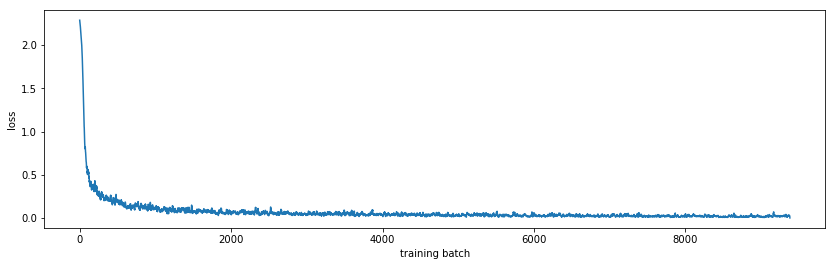

In [180]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

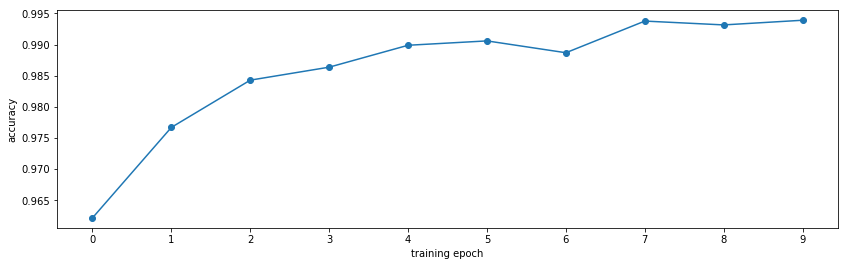

In [181]:
plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies, marker='o')

In [184]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[ 975    0    0    0    0    0    1    2    2    0]
 [   0 1122    3    1    0    1    1    4    2    1]
 [   1    0 1027    0    1    0    0    3    0    0]
 [   1    0    2 1000    0    2    0    1    3    1]
 [   0    0    1    0  977    0    0    1    0    3]
 [   2    0    1   11    0  869    1    1    6    1]
 [   4    1    0    2    1    3  944    0    3    0]
 [   0    1    4    1    0    0    0 1021    1    0]
 [   2    0    3    0    0    1    0    3  962    3]
 [   1    2    0    1    4    1    0    5    1  994]]
F1 score: 0.989100
Accuracy score: 0.989100


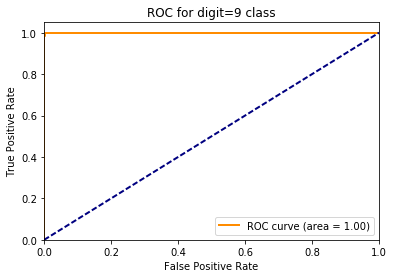

In [19]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 9
actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [185]:
print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t',param.numel())

Trainable parameters:
conv1.weight 	 500
conv1.bias 	 20
conv2.weight 	 25000
conv2.bias 	 50
fc1.weight 	 400000
fc1.bias 	 500
fc2.weight 	 5000
fc2.bias 	 10


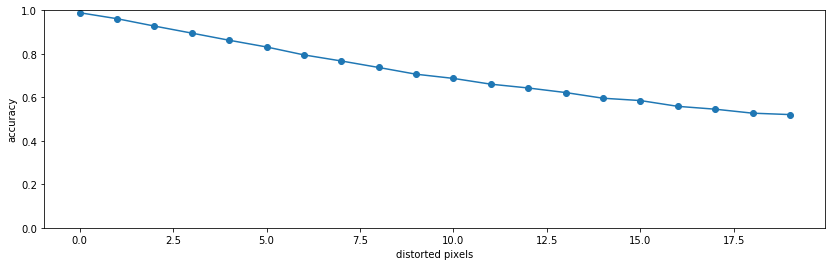

[0.9891, 0.9616, 0.9277, 0.8953, 0.8625, 0.8316, 0.7951, 0.7672, 0.7373, 0.7063, 0.687, 0.6605, 0.643, 0.622, 0.5959, 0.5852, 0.5586, 0.5455, 0.5272, 0.5207]


In [188]:
def distort(x, num_pixels=1, value=1.0):
    for _ in range(num_pixels):
        x[0][int(random()*28)][int(random()*28)] = value
    return x

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

def plot_accuracies(distorted_pixels, accuracies):
    clear_output()
    plt.figure(figsize=(14, 4))
    plt.xlabel('distorted pixels')
    plt.ylabel('accuracy')
    plt.ylim((0, 1))
    plt.plot(distorted_pixels, accuracies, marker='o')
    plt.show()

distorted_pixels = []
accuracies = []
for i in range(0, 20):
    my_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data',
            train=False,
            transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Lambda(lambda x: distort(x, num_pixels=i, value=5.0)),
               transforms.Normalize((0.1307,), (0.3081,)),
            ])
        ),
        batch_size=1000,
        shuffle=True)
    actuals, predictions = test_label_predictions(model, device, my_test_loader)
    distorted_pixels.append(i)
    accuracies.append(accuracy_score(actuals, predictions))
    plot_accuracies(distorted_pixels, accuracies)

print(accuracies)

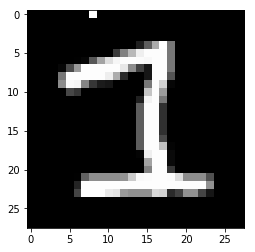

In [227]:
dataset = datasets.MNIST(
    '../data',
    train=False,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Lambda(lambda x: set_pixel(x, 0, 8)),
    ])
)
x, _ = dataset[3906] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

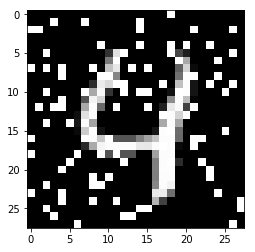

In [190]:
dataset = datasets.MNIST(
    '../data',
    train=False,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Lambda(lambda x: distort(x, num_pixels=100)),
    ])
)
x, _ = dataset[4] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

In [225]:
def set_pixel(x, i, j, value=1.0):
    x[0][i][j] = value
    return x

def misclassified_images(actuals, predictions):
    vuls = []
    for i in range(len(actuals)):
        if actuals[i] != predictions[i]:
            vuls.append(i)
    return set(vuls)

my_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=False,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,)),
        ])
    ),
    batch_size=1000,
    shuffle=False)
actuals, predictions = test_label_predictions(model, device, my_test_loader)
base_misclassifieds = misclassified_images(actuals, predictions)

vulnerable_images = set([])
for i in range(28):
    for j in range(28):
        my_test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Lambda(lambda x: set_pixel(x, i, j)),
                   transforms.Normalize((0.1307,), (0.3081,)),
                ])
            ),
            batch_size=1000,
            shuffle=False)
        actuals, predictions = test_label_predictions(model, device, my_test_loader)
        misc = misclassified_images(actuals, predictions)
        actual_vulnerables = misc.difference(base_misclassifieds)
        print('(%s, %s) vulnerables: %s' % (i, j, actual_vulnerables))
        for a in actual_vulnerables:
            print('--> %s is %s, classified as %s' % (a, actuals[a], predictions[a]))
        vulnerable_images.update(actual_vulnerables)

print(len(base_misclassifieds), len(vulnerable_images))

(0, 0) vulnerables: set()
(0, 1) vulnerables: set()
(0, 2) vulnerables: set()
(0, 3) vulnerables: set()
(0, 4) vulnerables: set()
(0, 5) vulnerables: set()
(0, 6) vulnerables: set()
(0, 7) vulnerables: set()
(0, 8) vulnerables: {3906}
--> 3906 is 1, classified as 3
(0, 9) vulnerables: {3906}
--> 3906 is 1, classified as 3
(0, 10) vulnerables: set()
(0, 11) vulnerables: {3906}
--> 3906 is 1, classified as 3
(0, 12) vulnerables: {3906}
--> 3906 is 1, classified as 3
(0, 13) vulnerables: {3906}
--> 3906 is 1, classified as 3
(0, 14) vulnerables: set()
(0, 15) vulnerables: set()
(0, 16) vulnerables: {2280}
--> 2280 is 3, classified as 5
(0, 17) vulnerables: {2280}
--> 2280 is 3, classified as 5
(0, 18) vulnerables: {2280, 5203}
--> 2280 is 3, classified as 5
--> 5203 is 1, classified as 7
(0, 19) vulnerables: {2280, 5203}
--> 2280 is 3, classified as 5
--> 5203 is 1, classified as 7
(0, 20) vulnerables: set()
(0, 21) vulnerables: set()
(0, 22) vulnerables: set()
(0, 23) vulnerables: set()
